In [275]:
import sys
sys.path.append('../../../util')
from ImageGenerator import ImageGenerator
from Grapher import Grapher

import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
from mpl_toolkits.mplot3d import Axes3D

In [9]:
img_gen = ImageGenerator(500, 500, 100)

# Most basic, easiest image with 64 solid well separated cells
_, centers_1 = img_gen.make_ellipsoidal_image(
    25,
    25,
    10,
    200,
    200,
    10,
    fname = "solid_64_cell_25_rad_1",
)

4 cells will be drawn on a 500 (x) by 500 (y) by 100 (z) image
Saved tif as:  solid_64_cell_25_rad_1.tif  at  solid_64_cell_25_rad_1.tif
Saved csv as:  solid_64_cell_25_rad_1_centers.csv  at  solid_64_cell_25_rad_1_centers.csv


In [11]:
img_gen = ImageGenerator(500, 500, 100)

# Most basic, easiest image with 64 solid well separated cells
_, centers_1 = img_gen.make_ellipsoidal_image(
    25,
    25,
    10,
    200,
    200,
    40,
    fname = "test_2",
)

1 cells will be drawn on a 500 (x) by 500 (y) by 100 (z) image
Saved tif as:  test_2.tif  at  test_2.tif
Saved csv as:  test_2_centers.csv  at  test_2_centers.csv


In [12]:
print(centers_1)

[[224, 224, 49]]


## Testing `np.random`

#### uniform

In [21]:
s = np.random.uniform(0, 2*np.pi, 1000)
# print(s)

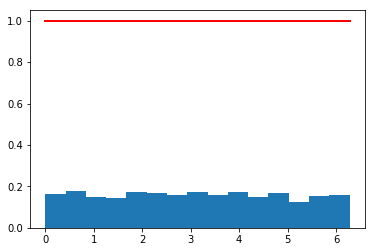

In [22]:
count, bins, ignored = plt.hist(s, 15, normed=True)
plt.plot(bins, np.ones_like(bins), linewidth=2, color='r')
plt.show()

#### normal

In [35]:
mu = 0
sigma = np.pi/3
s = np.random.normal(mu, sigma, 1000)

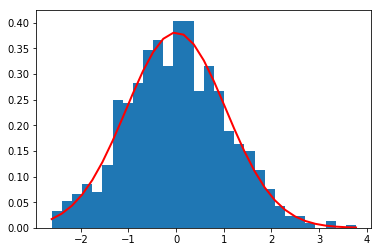

In [36]:
count, bins, ignored = plt.hist(s, 30, normed=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()

## Getting starting point from sphere

In [223]:
def sample_spherical(npoints, ndim=3):
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    return vec.reshape((1,3))

In [224]:
start_pt = sample_spherical(1)
print(start_pt)

[[ 0.57761641  0.78803479 -0.21297995]]


In [206]:
centers_1 = np.array(centers_1)
print(centers_1)

[[224 224  49]]


In [226]:
start_pt *= 5
pts = [seed]
pt = start_pt
print(pts)
pt = pt[0]
pt += pts[0]
pts.append(pt)
print(pt)

[[49, 224, 224]]
[  51.88808204  227.94017393  222.93510024]


In [227]:
dist = np.linalg.norm(pts[1]-pts[0])
print(dist)

5.0


In [209]:
print(pts)

[[49, 224, 224], array([  53.9026254 ,  224.17599859,  223.03393134])]


## whole function for generating segments

In [277]:
def gen_points(start, num_segs, seg_len):
    start_pt = sample_spherical(1)
    start_pt *= seg_len
    pts = [start]
    pt = start_pt
    pt = pt[0]
    pt += pts[0]
    pts.append(pt)
    
    for i in range(num_segs-1):
        next_pt = get_next_pt(pts[0+i], pts[1+i], seg_len)
        pts.append(next_pt)
    return np.array(pts)

## Generating next coordinate

In [323]:
def get_next_pt(prev_pt, curr_pt, seg_length, bound=True):
    diff = curr_pt - prev_pt
#     next_pt = curr_pt + diff
    vec = [np.random.normal(diff[0], seg_length/4),
           np.random.normal(diff[1], seg_length/4),
           np.random.normal(diff[2], seg_length/4)]
    vec = np.array(vec)
    vec /= np.linalg.norm(vec)  # normalizing to magnitude of 1
    vec *= seg_length
    next_pt = curr_pt + vec
    while bound and (next_pt[0] < 0 or next_pt[0] >= 100):
        vec = [np.random.normal(diff[0], seg_length/3),
           np.random.normal(diff[1], seg_length/3),
           np.random.normal(diff[2], seg_length/3)]
        vec = np.array(vec)
        vec /= np.linalg.norm(vec)  # normalizing to magnitude of 1
        vec *= seg_length
        next_pt = curr_pt + vec
    return next_pt

In [211]:
print(pts)

[[49, 224, 224], array([  53.9026254 ,  224.17599859,  223.03393134])]


In [212]:
next_pt = get_next_pt(pts[0], pts[1], 5)
print(next_pt)
pts.append(next_pt)

[  54.74278681  227.67015162  226.51028337]


In [213]:
print(pts)

[[49, 224, 224], array([  53.9026254 ,  224.17599859,  223.03393134]), array([  54.74278681,  227.67015162,  226.51028337])]


In [214]:
for i in range(5):
    next_pt = get_next_pt(pts[1+i], pts[2+i], 5)
    pts.append(next_pt)
print(pts)

[[49, 224, 224], array([  53.9026254 ,  224.17599859,  223.03393134]), array([  54.74278681,  227.67015162,  226.51028337]), array([  55.58294821,  231.16430465,  229.98663539]), array([  56.42310962,  234.65845768,  233.46298742]), array([  57.26327102,  238.15261071,  236.93933945]), array([  58.10343243,  241.64676374,  240.41569147]), array([  58.94359383,  245.14091678,  243.8920435 ])]


## Plotting

In [215]:
image = tiff.imread('test_2.tif')
print(image.shape)

(100, 500, 500, 3)


In [218]:
def plot_csv_on_tif(centroids, reference_img_path, tif_output_path):
    """Given a CSV file, plots the co-ordinates in the CSV on a TIF stack"""
    def _parse_int_array(arr):
        return [int(item) for item in arr]

    def _draw_square(image, coord, size=2):
        coord = _parse_int_array(coord)
        shape_z, shape_y, shape_x = image.shape
        z_range = range(max(0, coord[0]-size), min(shape_z, coord[0]+size))
        y_range = range(max(0, coord[1]-size), min(shape_y, coord[1]+size))
        x_range = range(max(0, coord[2]-size), min(shape_x, coord[2]+size))

        for z in z_range:
            for y in y_range:
                for x in x_range:
                    image[z, y, x] = 255

        return image

    ref_image = tiff.imread(reference_img_path)
    if len(ref_image.shape) == 4:
        ref_image = ref_image[:,:,:,0]
    shape_z, shape_y, shape_x = ref_image.shape

    annotated_image = np.zeros((shape_z, shape_y, shape_x))

    for i, c in enumerate(centroids):
        annotated_image = _draw_square(annotated_image, c)
        
    tiff.imsave(tif_output_path, annotated_image.astype(np.uint8))

In [314]:
def plot_lines_on_tif(points, reference_img_path, tif_output_path, overwrite=False):
    """Given a CSV file, plots the co-ordinates in the CSV on a TIF stack"""
    def _parse_int_array(arr):
        return [int(item) for item in arr]

    def _draw_square(image, coord, size=2):
        coord = _parse_int_array(coord)
        shape_z, shape_y, shape_x = image.shape
        z_range = range(max(0, coord[0]-size), min(shape_z, coord[0]+size))
        y_range = range(max(0, coord[1]-size), min(shape_y, coord[1]+size))
        x_range = range(max(0, coord[2]-size), min(shape_x, coord[2]+size))

        for z in z_range:
            for y in y_range:
                for x in x_range:
                    image[z, y, x] = 255

        return image
    
    ref_image = tiff.imread(reference_img_path)
    if len(ref_image.shape) == 4:
        ref_image = ref_image[:,:,:,0]
    shape_z, shape_y, shape_x = ref_image.shape

    if overwrite:
        annotated_image = ref_image
    else:
        annotated_image = np.zeros((shape_z, shape_y, shape_x))
        
    for i in range(1, len(points)):
        diff = points[i] - points[i-1]
        mag = np.linalg.norm(diff)
        for j in range(0, int(mag)):
            pt = points[i-1] + (float(j) / mag) * diff
            annotated_image = _draw_square(annotated_image, pt)
        
    tiff.imsave(tif_output_path, annotated_image.astype(np.uint8))

In [221]:
plot_lines_on_tif(pts, 'test_2.tif', 'test_2_lines.tif')

In [219]:
plot_csv_on_tif(pts, 'test_2.tif', 'test_4_csv.tif')

In [217]:
print(pts)

[[49, 224, 224], array([  53.9026254 ,  224.17599859,  223.03393134]), array([  54.74278681,  227.67015162,  226.51028337]), array([  55.58294821,  231.16430465,  229.98663539]), array([  56.42310962,  234.65845768,  233.46298742]), array([  57.26327102,  238.15261071,  236.93933945]), array([  58.10343243,  241.64676374,  240.41569147]), array([  58.94359383,  245.14091678,  243.8920435 ])]


In [222]:
print(pts[1]-pts[0])

print(pts[6]-pts[5])

[ 4.9026254   0.17599859 -0.96606866]
[ 0.8401614   3.49415303  3.47635203]


## Testing

In [225]:
seed = [centers_1[0,2], centers_1[0,1], centers_1[0,0]]

In [309]:
pts1 = gen_points(seed, num_segs=30, seg_len=20)
print(pts1)
plot_lines_on_tif(pts1, 'test_2.tif', 'test_1_lines.tif')

[[  49.          224.          224.        ]
 [  44.49186993  215.39275998  241.48119511]
 [  45.21561775  201.39319     255.74612517]
 [  40.90303528  185.17222826  266.62187952]
 [  35.3546685   172.31217485  280.89894688]
 [  21.94672666  164.82270226  293.71046107]
 [  10.41732273  154.54444278  306.41598062]
 [   7.83114926  137.58477746  316.6961294 ]
 [  11.76971342  119.99027321  325.35182884]
 [  20.09600603  103.97307526  333.96125514]
 [  24.21246861   90.82164155  348.45589301]
 [  34.30135796   88.36559724  365.54922967]
 [  48.75030232   77.48848355  374.08833996]
 [  56.23768279   61.51771308  383.51562082]
 [  56.34268104   41.68528588  386.09705579]
 [  59.48706592   22.44930988  381.61486088]
 [  59.3127493     3.17195785  376.29007804]
 [  56.11881331  -16.5596355   375.60963931]
 [  48.94543737  -34.84956284  371.86514532]
 [  38.95958297  -49.55353868  362.69585928]
 [  32.47939614  -64.27439332  350.80873947]
 [  33.00029794  -77.571892    335.87872975]
 [  40.346

[ 224.          241.48119511  255.74612517  266.62187952  280.89894688
  293.71046107  306.41598062  316.6961294   325.35182884  333.96125514
  348.45589301  365.54922967  374.08833996  383.51562082  386.09705579
  381.61486088  376.29007804  375.60963931  371.86514532  362.69585928
  350.80873947  335.87872975  324.42495737  326.55463561  320.82648468
  319.91231126  320.35618581  328.52006239  344.0554586   352.05488074
  363.13659999]


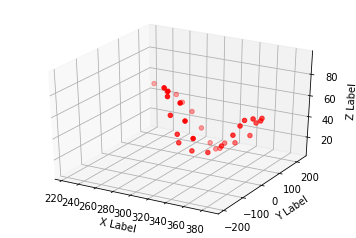

In [310]:
zs = pts1[:,0]
ys = pts1[:,1]
xs = pts1[:,2]
print(xs)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs, ys, zs, c=c, marker=m)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [264]:
print(pts[1]-pts[0])
print(np.linalg.norm(pts[1]-pts[0]))
print(pts[6]-pts[5])


[ 19.3604991   -1.07942204   4.89958391]
20.0
[  3.21257404  14.11257955  13.8026978 ]


In [241]:
test = tiff.imread('test_3_lines.tif')
print(test.shape)

(100, 500, 500)


In [257]:
test[87,  353,  352]

255

## Test 2

In [311]:
print(seed)

[49, 224, 224]


In [322]:
pts2 = gen_points([78, 300, 400], num_segs=20, seg_len=20)
print(pts2)
plot_lines_on_tif(pts2, 'test_2.tif', 'test_2_lines.tif')

pts3 = gen_points([10, 130, 120], num_segs=20, seg_len=20)
print(pts3)
plot_lines_on_tif(pts3, 'test_2_lines.tif', 'test_2_lines.tif', overwrite=True)

[[  78.          300.          400.        ]
 [  90.37975444  286.79229949  391.4971577 ]
 [  98.78815072  277.61310802  375.84336212]
 [  86.9934855   261.63003478  373.51371793]
 [  72.27051132  248.0943833   373.37169603]
 [  55.19843961  238.21971287  376.69363096]
 [  39.42291804  227.10048443  381.93726308]
 [  20.83158054  220.34807295  384.89819356]
 [   2.66919518  212.3934365   387.51573383]
 [   2.9719176   200.95743063  403.92079796]
 [   2.70030824  190.47650762  420.95242974]
 [   8.20122479  174.39986204  431.50142893]
 [  11.22935143  155.02984447  435.45527118]
 [  13.16775114  135.82158453  430.23173248]
 [  12.43210141  115.85954579  429.24389186]
 [  12.62546618   96.20815776  432.95678273]
 [   8.86973937   76.7215625   435.44015165]
 [   3.0580721    57.6841264   437.38965166]
 [   3.48945352   38.07842854  441.31782191]
 [  12.88020069   24.24903103  452.29787802]
 [  18.33375726    9.11161691  464.17716311]]
[[  10.          130.          120.        ]
 [  -3.86

In [279]:
test = tiff.imread('test_4_lines.tif')
print(test.shape)

(100, 500, 500)


In [284]:
test[98,  440,  450]

255

In [290]:
zs = pts2[:,0]
ys = pts2[:,1]
xs = pts2[:,2]
print(xs)

[ 224.          243.34083962  257.14353741  270.94623521  284.74893301
  298.5516308   312.3543286   326.1570264   339.9597242   353.76242199
  367.56511979  381.36781759  395.17051539  408.97321318  422.77591098
  436.57860878  450.38130657  464.18400437  477.98670217  491.78939997
  505.59209776]


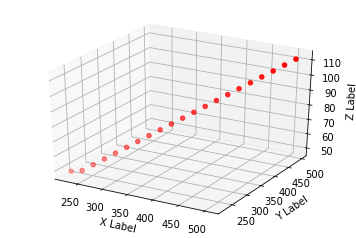

In [288]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs, ys, zs, c=c, marker=m)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [289]:
print(len(pts_2))
print(pts_2[1]-pts_2[0])
print(np.linalg.norm(pts[1]-pts[0]))
print(pts_2[6]-pts_2[5])
print(pts_2[11] - pts_2[10])


21
[  1.24619782   4.93750078  19.34083962]
20.0
[  3.21257404  14.11257955  13.8026978 ]
[  3.21257404  14.11257955  13.8026978 ]


## Test 3

In [321]:
pts1 = gen_points([47, 450, 240], num_segs=20, seg_len=20)
print(pts1)
plot_lines_on_tif(pts1, 'test_2.tif', 'test_3_lines.tif')

pts2 = gen_points([78, 300, 400], num_segs=20, seg_len=20)
print(pts2)
plot_lines_on_tif(pts2, 'test_3_lines.tif', 'test_3_lines.tif', overwrite=True)

pts3 = gen_points([10, 130, 120], num_segs=20, seg_len=20)
print(pts3)
plot_lines_on_tif(pts3, 'test_3_lines.tif', 'test_3_lines.tif', overwrite=True)

[[  47.          450.          240.        ]
 [  49.96858678  436.99555385  225.09792388]
 [  60.32492731  431.75005087  208.8120125 ]
 [  70.87987811  421.49252537  195.27036621]
 [  86.72970582  415.84998825  184.45626726]
 [  95.25011395  398.58081765  179.05456455]
 [  97.34821154  378.90114192  176.17214374]
 [  99.22114121  359.02704451  174.94235249]
 [  97.71089316  340.18872806  168.39735559]
 [  87.40193498  323.3504259   165.20408746]
 [  81.84025535  306.10497036  156.73874736]
 [  76.86548454  291.13442194  144.44507682]
 [  80.25951847  272.50579594  138.00653452]
 [  71.15798989  258.78714456  126.65044444]
 [  66.52507383  251.23016412  108.72202746]
 [  69.13072264  241.78430499   91.28682343]
 [  73.08361558  243.25832232   71.73683851]
 [  81.39018582  243.71023875   53.54902219]
 [  88.58984408  239.54998555   35.35954133]
 [  91.90941615  235.74868968   16.00674848]
 [  92.67259204  228.94004837   -2.78314152]]
[[  7.80000000e+01   3.00000000e+02   4.00000000e+02]


[ 224.          210.43487948  207.31095979  189.20776443  178.73667705
  175.35688465  166.99429053  168.22652781  160.60101124  160.62161637
  164.49058315  172.51059466  179.80025009  192.66174916  210.51599879
  216.27608153  223.74045229  220.17755628  205.00703021  194.78499156
  194.67120862]


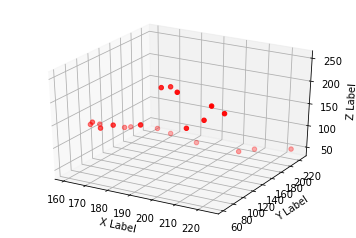

In [300]:
zs = pts3[:,0]
ys = pts3[:,1]
xs = pts3[:,2]
print(xs)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs, ys, zs, c=c, marker=m)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

## Test 4

In [324]:
pts1 = gen_points([47, 450, 240], num_segs=20, seg_len=20)
print(pts1)
plot_lines_on_tif(pts1, 'test_2.tif', 'test_4_lines.tif')

pts2 = gen_points([78, 300, 400], num_segs=20, seg_len=20)
print(pts2)
plot_lines_on_tif(pts2, 'test_4_lines.tif', 'test_4_lines.tif', overwrite=True)

pts3 = gen_points([10, 130, 120], num_segs=20, seg_len=20)
print(pts3)
plot_lines_on_tif(pts3, 'test_4_lines.tif', 'test_4_lines.tif', overwrite=True)

pts3 = gen_points([30, 430, 100], num_segs=20, seg_len=20)
print(pts3)
plot_lines_on_tif(pts3, 'test_4_lines.tif', 'test_4_lines.tif', overwrite=True)

[[  47.          450.          240.        ]
 [  45.8393582   440.58574107  222.39248344]
 [  41.04031648  425.63159339  210.00932286]
 [  44.63500398  408.40454181  200.50632779]
 [  40.18395306  389.22032748  197.02005954]
 [  28.41677284  373.4586957   193.4000549 ]
 [  14.74443615  358.97467986  191.58884144]
 [   5.34475773  341.66940769  195.07791021]
 [  11.32910496  323.23571645  200.01619083]
 [  19.88337054  305.75673975  204.63245706]
 [  28.07329648  287.95045331  208.61507884]
 [  35.99183474  272.48601911  218.52204743]
 [  47.88414772  257.66980194  224.77125545]
 [  60.68997022  245.11800149  233.62920192]
 [  69.1333747   235.9826022   249.28977025]
 [  78.31102221  230.20996375  266.09594267]
 [  88.45924791  227.79182601  283.1595333 ]
 [  94.54478862  225.66864101  302.09252777]
 [  96.50586324  208.27700135  311.77163187]
 [  94.91944504  189.42505192  318.25910288]
 [  89.37049862  170.77849226  322.89753004]]
[[  78.          300.          400.        ]
 [  83.02

## Test 5

In [326]:
pts1 = gen_points([47, 450, 240], num_segs=30, seg_len=20)
# print(pts1)
plot_lines_on_tif(pts1, 'test_2.tif', 'test_5_lines.tif')

pts2 = gen_points([78, 300, 400], num_segs=30, seg_len=20)
# print(pts2)
plot_lines_on_tif(pts2, 'test_5_lines.tif', 'test_5_lines.tif', overwrite=True)

pts3 = gen_points([10, 130, 120], num_segs=30, seg_len=20)
# print(pts3)
plot_lines_on_tif(pts3, 'test_5_lines.tif', 'test_5_lines.tif', overwrite=True)

pts3 = gen_points([30, 430, 100], num_segs=30, seg_len=20)
# print(pts3)
plot_lines_on_tif(pts3, 'test_5_lines.tif', 'test_5_lines.tif', overwrite=True)

## Generating two angles (deprecated)

In [39]:
# a1 = np.random.uniform(0, 2*np.pi, 1)
a1 = np.random.uniform(0, 2*np.pi)
print('angle 1:', a1)

angle 1 0.32553356379821


In [40]:
a2 = np.random.normal(0, np.pi/3)
while (a2 < 0 or a2 > np.pi):
    a2 = np.random.normal(0, np.pi/3)
print('angle 2:', a2)


angle 2: 0.23198539474436242


In [295]:
np.random.normal(0, 1)

1.8780920815298818